In [1]:
# Import library and models
# NB: you need to import binary_model into the python path
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Standard library
import numpy as np
import matplotlib.pyplot as plt
#!pip install tqdm 
from tqdm import tqdm

# The model
from model.binaryModel import binaryModel
from model.utils import initRandomArchitecture, initGaussianWeights, initUniformWeights, dataPath

In [2]:
# The experiment
sim = 'statisticalAnalysis'
distribution_weight = 'normal'
experiment = 'display_phase_transition'
experiment = experiment + '_' + distribution_weight

N = 10000
duration = 2000
nbTrial = 10
K = 16 # Connectivity degree of the graph 
meanWeight = -0.1 # Average weights for the normal distribution
# List of standard deviation sigma (of the normal distribution)
sigmas_zoom = list([0.0607, 0.0614, 0.0621, 0.0629, 0.0636, 0.0643, 0.0643, 0.0657, 0.0664, 0.0671, 0.0679,
                 0.0686, 0.0693])
sigmas = list(np.arange(0.01, 0.06, 0.005))+\
        list(np.arange(0.06, 0.1, 0.01))+\
        sigmas_zoom+\
        list(np.arange(0.1, 0.2, 0.01))+\
        list(np.arange(0.2, 1, 0.1))+\
        list(np.arange(1, 11, 1))

print(f'The model will be evaluated on {len(sigmas)} values of sigma(W):')
print('sigma(W) =', sigmas)

The model will be evaluated on 56 values of sigma(W):
sigma(W) = [0.01, 0.015, 0.019999999999999997, 0.024999999999999998, 0.03, 0.034999999999999996, 0.039999999999999994, 0.045, 0.049999999999999996, 0.05499999999999999, 0.06, 0.06999999999999999, 0.07999999999999999, 0.08999999999999998, 0.09999999999999998, 0.0607, 0.0614, 0.0621, 0.0629, 0.0636, 0.0643, 0.0643, 0.0657, 0.0664, 0.0671, 0.0679, 0.0686, 0.0693, 0.1, 0.11, 0.12, 0.13, 0.13999999999999999, 0.14999999999999997, 0.15999999999999998, 0.16999999999999998, 0.17999999999999997, 0.18999999999999995, 0.2, 0.30000000000000004, 0.4000000000000001, 0.5000000000000001, 0.6000000000000001, 0.7000000000000002, 0.8000000000000003, 0.9000000000000001, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [3]:
# Create the model
optionData = {'spikeCount':True, 'indexActive':False} # Option for saving data
brain = binaryModel(N, sim=sim, experiment=experiment)
seedConnectivity = 747
initRandomArchitecture(brain, K, seed=seedConnectivity) # Fixed architecture

In [4]:
# Function to check if reservoir is ran already

def check_if_ran(sim, experiment, N, K, meanWeight):
    #Check network has not been run already
    pathBrain = dataPath(sim, experiment, N, K, meanWeight)
    file_path = pathBrain + f"/metadata_N{N}_K{K}*T{nbTrial}_W{meanWeight}_std{sigma}.npy"
    if os.path.exists(file_path):
        print('Network already run, next...\n \n')
        return True
    else:
        return False

In [5]:
# Run the model

for sigma in tqdm(sigmas):
    sigma = np.round(sigma, 4)
    optionData = {'spikeCount':True, 'indexActive':False}
    for t in range(nbTrial):
        
        # Check if the network is already run
        check = check_if_ran(sim, experiment, N, K, meanWeight)
        if check:
            continue
        
        # Select weight distribution
        if distribution_weight == 'normal':
            initGaussianWeights(brain, meanWeight, sigma, seed=t*100)
        elif distribution_weight == 'uniform':
            initUniformWeights(brain, meanWeight, sigma, seed=t*100)
        
        # Run simulation
        brain.displayInfoNetwork()
        brain.initRandomState(0.2, seed=t*100) # Initialize the state of the reservoir
        brain.run(duration, **optionData)
        
        # Reset the network
        brain.reset()
    
    # Save data and metadata
    brain.saveData(**optionData)
    brain.saveMetadata()
    brain.reset(deep=True)


  0%|          | 0/56 [00:00<?, ?it/s]

---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----


  2%|▏         | 1/56 [00:21<19:34, 21.35s/it]

c:\\Users\Manu\Documents\GitHub\binary_model\/results/statisticalAnalysis\display_phase_transition_normal\/N10000_K16/mu-0.1/std0.01
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----


  4%|▎         | 2/56 [00:42<18:54, 21.01s/it]

c:\\Users\Manu\Documents\GitHub\binary_model\/results/statisticalAnalysis\display_phase_transition_normal\/N10000_K16/mu-0.1/std0.015
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----


  5%|▌         | 3/56 [01:03<18:36, 21.07s/it]

c:\\Users\Manu\Documents\GitHub\binary_model\/results/statisticalAnalysis\display_phase_transition_normal\/N10000_K16/mu-0.1/std0.02
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----


  7%|▋         | 4/56 [01:24<18:27, 21.29s/it]

c:\\Users\Manu\Documents\GitHub\binary_model\/results/statisticalAnalysis\display_phase_transition_normal\/N10000_K16/mu-0.1/std0.025
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----


  9%|▉         | 5/56 [01:46<18:09, 21.37s/it]

c:\\Users\Manu\Documents\GitHub\binary_model\/results/statisticalAnalysis\display_phase_transition_normal\/N10000_K16/mu-0.1/std0.03
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----


 11%|█         | 6/56 [02:06<17:27, 20.95s/it]

c:\\Users\Manu\Documents\GitHub\binary_model\/results/statisticalAnalysis\display_phase_transition_normal\/N10000_K16/mu-0.1/std0.035
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----


 12%|█▎        | 7/56 [02:28<17:28, 21.39s/it]

c:\\Users\Manu\Documents\GitHub\binary_model\/results/statisticalAnalysis\display_phase_transition_normal\/N10000_K16/mu-0.1/std0.04
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----


 14%|█▍        | 8/56 [02:52<17:35, 21.98s/it]

c:\\Users\Manu\Documents\GitHub\binary_model\/results/statisticalAnalysis\display_phase_transition_normal\/N10000_K16/mu-0.1/std0.045
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----


 16%|█▌        | 9/56 [03:14<17:15, 22.03s/it]

c:\\Users\Manu\Documents\GitHub\binary_model\/results/statisticalAnalysis\display_phase_transition_normal\/N10000_K16/mu-0.1/std0.05
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----


 18%|█▊        | 10/56 [03:36<16:52, 22.00s/it]

c:\\Users\Manu\Documents\GitHub\binary_model\/results/statisticalAnalysis\display_phase_transition_normal\/N10000_K16/mu-0.1/std0.055
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----


 20%|█▉        | 11/56 [03:58<16:38, 22.20s/it]

c:\\Users\Manu\Documents\GitHub\binary_model\/results/statisticalAnalysis\display_phase_transition_normal\/N10000_K16/mu-0.1/std0.06
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----


 21%|██▏       | 12/56 [04:20<16:15, 22.17s/it]

c:\\Users\Manu\Documents\GitHub\binary_model\/results/statisticalAnalysis\display_phase_transition_normal\/N10000_K16/mu-0.1/std0.07
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----


 23%|██▎       | 13/56 [04:44<16:06, 22.49s/it]

c:\\Users\Manu\Documents\GitHub\binary_model\/results/statisticalAnalysis\display_phase_transition_normal\/N10000_K16/mu-0.1/std0.08
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----


 25%|██▌       | 14/56 [05:07<15:59, 22.84s/it]

c:\\Users\Manu\Documents\GitHub\binary_model\/results/statisticalAnalysis\display_phase_transition_normal\/N10000_K16/mu-0.1/std0.09
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----


 27%|██▋       | 15/56 [05:30<15:32, 22.73s/it]

c:\\Users\Manu\Documents\GitHub\binary_model\/results/statisticalAnalysis\display_phase_transition_normal\/N10000_K16/mu-0.1/std0.1
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----


 29%|██▊       | 16/56 [05:53<15:11, 22.78s/it]

c:\\Users\Manu\Documents\GitHub\binary_model\/results/statisticalAnalysis\display_phase_transition_normal\/N10000_K16/mu-0.1/std0.0607
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----


 30%|███       | 17/56 [06:17<15:08, 23.29s/it]

c:\\Users\Manu\Documents\GitHub\binary_model\/results/statisticalAnalysis\display_phase_transition_normal\/N10000_K16/mu-0.1/std0.0614
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----
---- RUN ! ----


 30%|███       | 17/56 [06:40<15:19, 23.57s/it]


KeyboardInterrupt: 

In [17]:
# Analyse the data

from model.utils import statisticsActivity
import glob 

def statisticActivity_over_sigma(meanWeight, N, K, nbTrial, I=0.2,
                                 sim='statisticalAnalysis', experiment='allDegree'):
       
    result_dir = dataPath(sim, experiment)
    analysis_folder = os.path.join(result_dir, sim)
    if not os.path.isdir(analysis_folder):
        os.makedirs(analysis_folder)
        
    # Figure
    avgLabel = r'$<<A>_t>_T}$'
    varLabel = r'$<\sigma^2_t(A)/N>_T$'
    xlabel = r'$|\sigma^{\star}|$'
    # title1 = 'average over trial of the time averaged activity'
    # title2 = 'average over trial of the time variance activity'
    fig = plt.figure()
    ax = fig.add_subplot(2, 1, 1)
    #ax.set_xlabel(xlabel)
    ax.set_ylabel(avgLabel)
    ax.set_title('Average')
    ax1 = fig.add_subplot(2, 1, 2)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(varLabel)
    ax1.set_title('Variance')
    
    avgAll = []
    varAll = []

    # data folder
    directory = dataPath(sim, experiment, N, K, meanWeights=meanWeight)
    filenames = glob.glob(directory + '/metadata_*T{0}*.npy'.format(nbTrial))
    stdWeights = []
    for filename in filenames:

        # Load datas
        metadata = np.load(filename, allow_pickle='TRUE').item()
        directoryActivity = metadata['dataPath']
        stdWeights.append(metadata['stdWeights'])
        fileData = metadata['spikeCountFile']
        duration = metadata['duration']
        idxStart = int(duration / 2)
        # Load activity data
        filepath = directoryActivity + '/' + fileData + '.npy'
        print(filepath)
        A_trials = np.load(filepath)

        # Global statistics
        avgTrials, varTrials = statisticsActivity(N, A_trials, idxStart)
        avgAll.append(avgTrials)
        varAll.append(varTrials)

    # plot average of all trials
    stdWeights = np.array(stdWeights)
    order = np.argsort(stdWeights)
    stdWeights = stdWeights[order]
    avgAll = np.array(avgAll)
    avgAll = avgAll[order]
    varAll = np.array(varAll)
    varAll = varAll[order]

    if meanWeight>0:
        marker = '^-'
        label = '$\sigma^{\star}>0$'
    elif meanWeight<0:
        marker = 'v-'
        label = '$\sigma^{\star}<0$'
    else:
        marker = 'o-'
        label = '$\mu=0$'
    
    if meanWeight != 0:
        x_axis = np.abs(stdWeights/meanWeight)
    else:
        x_axis = np.abs(stdWeights)

    ax.semilogx(x_axis, avgAll, marker, label=label)
    color = ax.get_lines()[-1].get_color()
    ax1.semilogx(x_axis, varAll, marker, color=color)

    plt.tight_layout()
    fig.savefig(analysis_folder + f'statActivity_sorted_N{N}_K{K}_d{duration}_T{nbTrial}.svg')


c:\\Users\Manu\Documents\GitHub\binary_model\/results/statisticalAnalysis\display_phase_transition_normal\/N10000_K16/mu-0.1/std0.01/spikeCount_N10000_K16_D2000_T10_W-0.1_std0.01.npy
c:\\Users\Manu\Documents\GitHub\binary_model\/results/statisticalAnalysis\display_phase_transition_normal\/N10000_K16/mu-0.1/std0.015/spikeCount_N10000_K16_D2000_T10_W-0.1_std0.015.npy
c:\\Users\Manu\Documents\GitHub\binary_model\/results/statisticalAnalysis\display_phase_transition_normal\/N10000_K16/mu-0.1/std0.02/spikeCount_N10000_K16_D2000_T10_W-0.1_std0.02.npy
c:\\Users\Manu\Documents\GitHub\binary_model\/results/statisticalAnalysis\display_phase_transition_normal\/N10000_K16/mu-0.1/std0.025/spikeCount_N10000_K16_D2000_T10_W-0.1_std0.025.npy
c:\\Users\Manu\Documents\GitHub\binary_model\/results/statisticalAnalysis\display_phase_transition_normal\/N10000_K16/mu-0.1/std0.03/spikeCount_N10000_K16_D2000_T10_W-0.1_std0.03.npy
c:\\Users\Manu\Documents\GitHub\binary_model\/results/statisticalAnalysis\display

NameError: name 'mu' is not defined

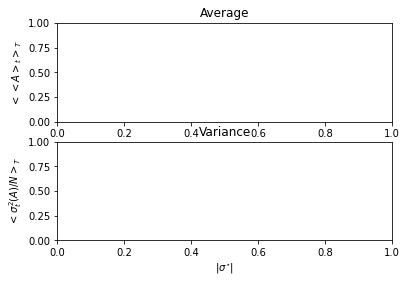

In [18]:
# Run analysis
statisticActivity_over_sigma(meanWeight, N, K, nbTrial,
                             sim=sim, experiment=experiment)